# Reverse-Engineering Thermal Diffusivity in Mulch

The insulation considered for over-summer snow storage uses a thick layer of mulch. From the perspective of heat transfer, mulch is a complex material which can neither be described as homogeneous nor as porous. The local void volume fraction varies significantly and can be of the order of the mulch volume fraction. The mulch chips are anisotropic due to the natural alignment of wood fibers and porous. In the application of interest here, they hold significant humidity.

Not surprisingly, there is no known correlation for the apparent thermal conductivity of mulch. This notebook investigates the possibility of reverse-engineering this critical property from the temperature data collected at the Craftsbury site.

## Equations

We solve the unsteady heat equation over the insulation, assuming 1D heat transfer. The mulch is to be modeled by an apparent thermal diffusivity $\alpha$, which lumps together conduction in the wood chips, possible convection in the air cavities and evaporation. The resulting equation is

$$
\frac{\partial T}{\partial t}=\frac{\partial}{\partial x}\alpha\frac{\partial T}{\partial x}+q''
$$

where $\alpha$ may be a function of multiple variables including local temperature, depth, humidity, ...

$$
q'' = -h\Delta T
$$

$$
q'' = -h(T_f,\Delta T)\Delta T
$$

## Approach

We seek to solve this equation using the temperature at the top (underneath the reflective blanket) and the bottom (on the surface of the snow) of the insulation. The temperature signal at $10cm$ from the snow serves as the target our simulation should predict to a reasonable uncertainty. 

The above heat equation is discretized on a non-uniform 1D grid using second order finite differences and the Crank Nicolson time advancement method:

$$
\frac{T_i^{(n+1)}-T_i^{(n)}}{\Delta t}=\frac{1}{2}\left(\left.\frac{\delta}{\delta x}\alpha\frac{\delta T}{\delta x}\right\vert_i^{(n+1)}+\left.\frac{\delta}{\delta x}\alpha\frac{\delta T}{\delta x}\right\vert_i^{(n)}\right)+{q''}^{(n)}_i
$$

$$
\frac{T_i^{(n+1)}-T_i^{(n)}}{\Delta t}=\frac{1}{2}\left(a_iT_{i-1}^{(n+1)}+b_iT_{i}^{(n+1)}+c_iT_{i+1}^{(n+1)}+a_iT_{i-1}^{(n)}+b_iT_{i}^{(n)}+c_iT_{i+1}^{(n)}\right)+{q''}^{(n)}_i
$$

which is recast into the following linear system:

$$
-a_i\frac{\Delta t}{2}T_{i-1}^{(n+1)}+\left(1 -b_i\frac{\Delta t}{2}\right)T_{i}^{(n+1)}-c_i\frac{\Delta t}{2}T_{i+1}^{(n+1)}=a_i\frac{\Delta t}{2}T_{i-1}^{(n)}+\left(1+b_i\frac{\Delta t}{2}T_{i}^{(n)}\right)+c_i\frac{\Delta t}{2}T_{i+1}^{(n)}+\frac{\Delta t}{2}{q''}^{(n)}_i
$$

The system is solved as an inversion matrix $A.x=d$ where $A$ is a tridiagonal matrix of lower, main and upper diagonals $a_i$, $b_i$, $c_i$, respectively, $x$ is the vector of temperature nodes at time $n+1$ $x=[T_0^{(n+1)},...,T_i^{(n+1)},...,T_{nx-1}^{(n+1)}]^T$ and $d$ is a vector made of quantities calculated at time $n$.

The coefficients $a_i$, $b_i$, $c_i$ derive from:

$$
\left.\frac{\delta}{\delta x}\alpha\frac{\delta T}{\delta x}\right\vert_i^{(n)}=\cfrac{\alpha_{i+\frac{1}{2}}\cfrac{T_{i+1}^{(n)}-T_{i}^{(n)}}{x_{i+1}-x_{i}}-\alpha_{i-\frac{1}{2}}\cfrac{T_{i}^{(n)}-T_{i-1}^{(n)}}{x_{i}-x_{i-1}}}{x_{i+\frac{1}{2}}-x_{i-\frac{1}{2}}}
$$
with

$$
\alpha_{i+\frac{1}{2}}=\frac{\alpha_{i+1}+\alpha_i}{2}
$$

To reverse engineer the diffusivities of mulch and curing concrete blanket, we first assume that the diffusivities are constant and we can integrate the above equation in time using data collected over last summer.

Using the time evolution of experimentally measured temperatures at the top and bottom of the insulation layer, the heat equation is solved and the evolution in time of the temperature at 10 cm where a temperature probe is located, is stored. The optimum diffusivities must minimize the error between the simulated temperature signal and the experimental signal at 10 cm. The cost function is therefore:

$$
J(\alpha_\text{blanket},\alpha_\mathrm{mulch})=\min_{\alpha_\text{blanket},\alpha_\mathrm{mulch}}\left(\left\Vert T^\mathrm{sim}(t,z=10\mathrm{cm})-T^\mathrm{exp}(t,z=10\mathrm{cm})\right\Vert_n\right)
$$

where $n$ is the order of the norm




### Python set-up and useful functions

In [18]:
%matplotlib inline 
# plots graphs within the notebook

from IPython.display import display,Image, Latex
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

import numericaltools as numtools


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py


import sympy as sym


class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }


from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)


# Data

## Probe locations

### Reflective blanket + mulch + concrete curing blanket

<table style="width:100%">
  <tr>
    <th>HOBO</th>
    <th>Channel</th> 
    <th>Location</th>
    <th>Note</th>
  </tr>
  <tr>
    <td>934</td>
    <td>2</td>
    <td>46 cm</td>
    <td> </td>
  </tr>
  <tr>
    <td>811</td>
    <td>1</td>
    <td>30 cm</td>
    <td> below reflective</td>
  </tr>
  <tr>
    <td>934</td>
    <td>1</td>
    <td>10 cm</td>
    <td> </td>
  </tr>
  <tr>
    <td>811</td>
    <td>1</td>
    <td>0 cm</td>
    <td> on snow</td>
  </tr>
</table>






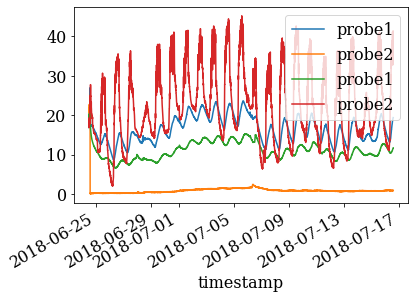

In [19]:
import pandas as pd
from pandas import Series

sensor811 = pd.read_excel("../Insulation/SN 20103811 2018-07-16 13_18_09 -0400.xlsx",sheet_name="DATA",
                          header=1,date_parser=[1],names=["#","timestamp","probe1","probe2"])
sensor811 = sensor811.set_index('timestamp')
sensor811 = sensor811.drop("#",axis=1)
sensor934 = pd.read_excel("../Insulation/SN 20366934 2018-07-16 13_19_37 -0400.xlsx",sheet_name="DATA",
                          header=1,date_parser=[0],names=["#","timestamp","probe1","probe2"])
sensor934 = sensor934.set_index('timestamp')
sensor934 = sensor934.drop("#",axis=1)
# print(sensor811.timestamp)
ax = sensor811.plot()
sensor934.plot(ax = ax)

alt0 = np.copy(sensor811.probe2)
alt30 = np.copy(sensor811.probe1)
alt10 = np.copy(sensor934.probe1)
alt46 = np.copy(sensor934.probe2)

In [20]:
tstart = sensor811.index[0]
print(tstart)
n = sensor811.shape[0]
print(n)
tend = sensor811.index[n-1]
print(tend)
print(pd.Timedelta(tend-tstart))


2018-06-24 11:53:58
6353
2018-07-16 13:13:58
22 days 01:20:00


# Time advancement



In [21]:
dt = 5*60.

dt_2 = dt / 2
oneday = 24*3600
Sim_time = 22*oneday

Nt = int(Sim_time/dt)
print(oneday)

86400


# Grid

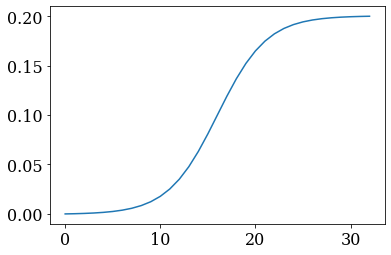

In [22]:
def create_grid(nz,lz,dzmin):
    z,gz = numtools.stretched_mesh(lz,nz,dzmin,28)
    
    dz = numtools.nufd(z)
    a_metrics = np.zeros(nz-2)
    c_metrics = np.zeros(nz-2)
    a_metrics[:] = 1. / ((z[1:-1] - z[0:-2])*(z[2:]-z[0:-2]))
    c_metrics[:] = 1. / ((z[2:] - z[1:-1])*(z[2:]-z[0:-2]))
    return z,dz,a_metrics,c_metrics
nz = 33
lz = 0.2
dzmin = lz/1000
z,dz,a_metrics,c_metrics = create_grid(nz,lz,dzmin)
plt.plot(z)
plt.show()
Dz = numtools.nufd(z)

# Simulation

In [23]:
from scipy.interpolate import interp1d
z10 = np.array([0.1])

In [24]:
'''
input: z, T_bot, T_top
output: Temperature based on 1-D heat transfer???
'''
def temperature_initialization(z,T_bot,T_top):
    return T_bot + (T_top - T_bot)*(z/z[-1]) 

## Constant Diffusivity Code

0.0 0.2 0.2


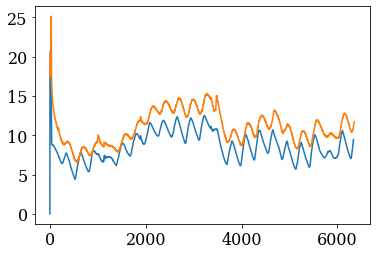

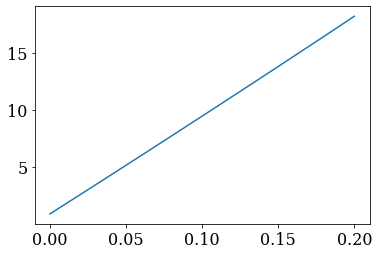

In [25]:
nz = 65 
lz = 0.2
dzmin = lz/1000 
z,dz,a_metrics,c_metrics = create_grid(nz,lz,dzmin)
print(z[0],z[-1],lz)
start_time = 0*oneday
end_time = 22*oneday
alpha = 1e-5

# coefficients of linear equation
a_rhs = np.zeros(nz-2)
b_rhs = np.zeros(nz-2)
c_rhs = np.zeros(nz-2)
a_lhs = np.zeros(nz-2)
b_lhs = np.zeros(nz-2)
c_lhs = np.zeros(nz-2)


T10 = np.zeros(Nt+1)


def bottom_T(i):
    global alt0
    return alt0[i]
def top_T(i):
    global alt30
    return alt30[i]
alpha_total_all = alpha*np.ones(nz)
a_lhs, b_lhs, c_lhs = numtools.diffusion_matrix_coefficients(alpha_total_all,
                                                                 dt_2,a_metrics,c_metrics)
istart = int(start_time/dt)
i = istart
T = temperature_initialization(z,alt0[i],alt30[i])
isample = 0
Sim_t = start_time
#     T[0] = bottom_T(i)
#     T[-1] = top_T(i)
if end_time > Sim_time:
    stop
while Sim_t < end_time:
#     print(Sim_t)
    Sim_t += dt
    a_rhs = np.copy(a_lhs)
    b_rhs = np.copy(b_lhs)
    c_rhs = np.copy(c_lhs)

    T_old = np.copy(T)
    T[0] = bottom_T(i)
    T[-1] = top_T(i)

    error = np.inf
    Titold = np.copy(T)
    j = 0
#     while error > 1e-5 and j < 100:
    alpha_total_all = alpha*np.ones(nz)
    a_lhs, b_lhs, c_lhs = numtools.diffusion_matrix_coefficients(alpha_total_all,
                                                                 dt_2,a_metrics,c_metrics)
    d = numtools.rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_old, T,dt_2,dt)
    T[1:-1] = numtools.TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)
#         error = np.linalg.norm(T-Titold,2)/np.mean(T)
#         Titold = np.copy(T)
#         j += 1
#             print(j,error)
    i += 1
    f = interp1d(z,T)
    T10[i] = f(z10)

plt.plot(T10)
plt.plot(alt10)
plt.show()
plt.plot(z,T)
plt.show()

In [26]:
""" 
inputs: 
alpha, vector, dimension 2, alpha[0]: curing concrete blanket thermal diffusivity, alpha[1]: mulch
L_ccb: thickness curing concrete blanket
start_time: t=0 for simulation
end_time: end of simulation
"""
def cst_diffusivity_sim(alpha,L_ccb,start_time,end_time):
    global z,dt, dt_2, Sim_time, Nt, z10, a_metrics, c_metrics,alt0,alt30,Dz

    a_rhs = np.zeros(nz-2)
    b_rhs = np.zeros(nz-2)
    c_rhs = np.zeros(nz-2)
    a_lhs = np.zeros(nz-2)
    b_lhs = np.zeros(nz-2)
    c_lhs = np.zeros(nz-2)

    Tprofiles = np.zeros((nz,Nt+1))
    T10 = np.zeros(Nt+1)


    def bottom_T(i):
        global alt0
        return alt0[i]
    def top_T(i):
        global alt30
        return alt30[i]
    mask_ccb = np.where(z < L_ccb)
    alpha_total_all = alpha[1]*np.ones(nz)
    alpha_total_all[mask_ccb] = alpha[0]
    istart = int(start_time/dt)
    i = istart
    T = temperature_initialization(z,alt0[i],alt30[i])
    a_lhs, b_lhs, c_lhs = numtools.diffusion_matrix_coefficients(alpha_total_all,dt_2,a_metrics,c_metrics)
    isample = 0
    Sim_t = start_time
#     T[0] = bottom_T(i)
#     T[-1] = top_T(i)
    if end_time > Sim_time:
        stop
    while Sim_t < end_time:

        Sim_t += dt
        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T)
        T[0] = bottom_T(i)
        T[-1] = top_T(i)

        error = np.inf
        Titold = np.copy(T)
        j = 0
        while error > 1e-5 and j < 100:
            a_lhs, b_lhs, c_lhs = numtools.diffusion_matrix_coefficients(alpha_total_all,dt_2,a_metrics,c_metrics)
            d = numtools.rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_old, T,dt_2,dt)
            T[1:-1] = numtools.TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)
            error = np.linalg.norm(T-Titold,2)/np.mean(T)
            Titold = np.copy(T)
            j += 1
#             print(j,error)
        i += 1
        f = interp1d(z,T)
        T10[i] = f(z10)
        Tprofiles[:,i] = np.copy(T)
#         print(i,Sim_t/Sim_time*100)
#         clear_output(wait=True)
    return T10,Tprofiles


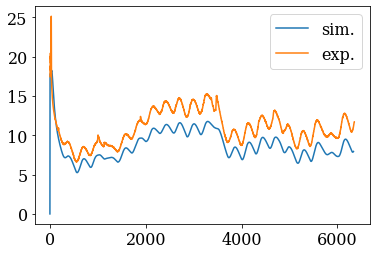

In [30]:
alpha_ccb = 2e-7
alpha_mulch = 2e-7
L_ccb = 0.0254
x = np.array([alpha_ccb, alpha_mulch])
nz = 33
lz = 0.2
dzmin = lz/100
start_time = 0*oneday
end_time = 22*oneday
istart = int(start_time/dt)
iend = int(end_time/dt)
z,dz,a_metrics,c_metrics = create_grid(nz,lz,dzmin)
T10,Tprofiles = cst_diffusivity_sim(x,L_ccb,start_time,end_time)
plt.plot(T10, label = "sim.")
plt.plot(alt10, label = "exp.")
plt.legend()
plt.show()

## Variable Alphas

In [31]:
nz = 33
lz = 0.2
dzmin = lz/1000
z,dz,a_metrics,c_metrics = create_grid(nz,lz,dzmin)

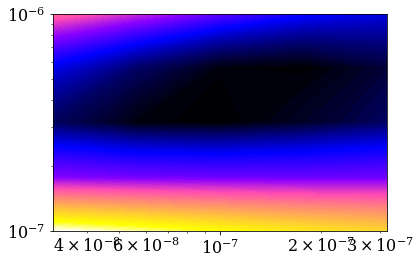

In [32]:
n = 5
alpha_mulch = np.logspace(-7,-6,n)
alpha_ccb = np.logspace(-7.5,-6.5,n)
X,Y = np.meshgrid(alpha_ccb,alpha_mulch)
error_alpha_cst = np.zeros((n,n))
i = 0
# T10_all = np.zeros((Nt+1,n))
i = 0
istart = int(start_time/dt)
iend =int(end_time/dt)
for alpha_m in alpha_mulch:
    j = 0
    for alpha_c in alpha_ccb:
        x = np.array([alpha_c,alpha_m])
        T10,Tprofiles = cst_diffusivity_sim(x, L_ccb,start_time,end_time)
#     T10_all[:,i] = np.copy(T10)
        
        error_alpha_cst[i,j] = np.std(T10[istart+1:iend] - alt10[istart+1:iend])
        print(i,j)
        j += 1
        clear_output(wait=True)
    i += 1
plt.contourf(X,Y,error_alpha_cst,100, cmap='gnuplot2')
plt.xscale('log')
plt.yscale('log')
plt.show()

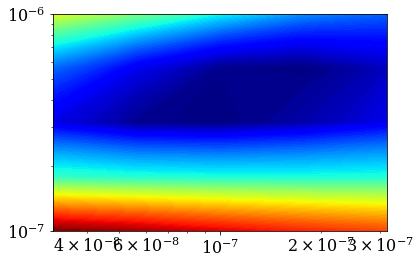

In [33]:
plt.contourf(X,Y,error_alpha_cst,100,cmap = 'jet')
plt.xscale('log')
plt.yscale('log')
plt.show()


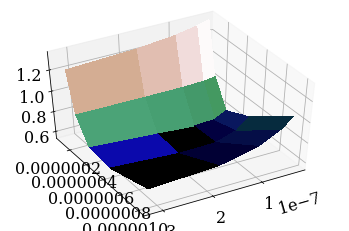

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(error_alpha_cst, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X,Y,error_alpha_cst, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)
ax.view_init(45, 60)
plt.show()

$$
J(\alpha)=\min_\alpha\left(\left\Vert T_{sim}(z=10cm,\alpha)-T_{HOBO}(z=10cm)\right\Vert\right)
$$


In [16]:
start_time = 10*oneday
end_time = 20*oneday
istart = int(start_time/dt)
iend = int(end_time/dt)
def cost_function(x):
    global z,dt, dt_2, Sim_time, Nt, z10, a_metrics, c_metrics,alt0 \
    ,alt30,alt10,istart,iend,start_time,end_time,L_ccb
    T10,Tprofiles = cst_diffusivity_sim(x,L_ccb,start_time,end_time)
    return np.std(T10[istart+1:iend] - alt10[istart+1:iend])
from scipy import optimize
x0 = [5e-7,3e-7]
x_opt = optimize.minimize(cost_function,x0, method='Nelder-Mead',
#                           jac='2-point',
#                           bounds=((1e-8,1e-6),(1e-7,1e-6)), 
                     options={'maxiter':50,'disp':True})
print(x_opt.nit,x_opt.message,x_opt.x)

/Users/dubief/Dropbox/CurrentLectures/ME144-S19/Project/snow-farming/Modeling/numericaltools.py:42: RuntimeWarning: overflow encountered in double_scalars
  xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
/Users/dubief/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/Users/dubief/Dropbox/CurrentLectures/ME144-S19/Project/snow-farming/Modeling/numericaltools.py:82: RuntimeWarning: overflow encountered in multiply
  d = a_rhs*T_old_all[:-2] + (b_rhs + 1)*T_old_all[1:-1] + c_rhs*T_old_all[2:]
/Users/dubief/Dropbox/CurrentLectures/ME144-S19/Project/snow-farming/Modeling/numericaltools.py:82: RuntimeWarning: invalid value encountered in add
  d = a_rhs*T_old_all[:-2] + (b_rhs + 1)*T_old_all[1:-1] + c_rhs*T_old_all[2:]


Optimization terminated successfully.
         Current function value: 0.286843
         Iterations: 24
         Function evaluations: 45
24 Optimization terminated successfully. [1.30112648e-07 3.85262403e-07]


[1.30112648e-07 3.85262403e-07]


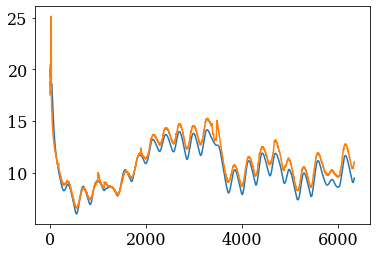

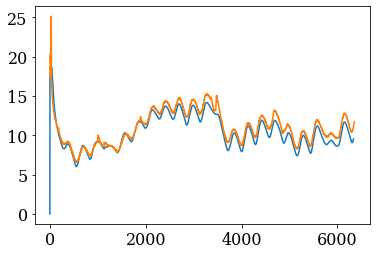

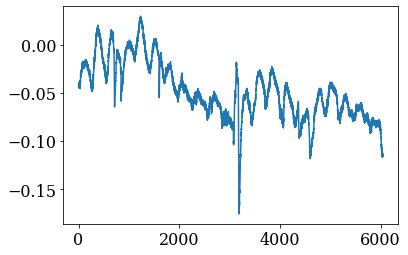

In [35]:
# x = np.array([1e-7, 5e-7])
x = x_opt.x
print(x)
T10,Tprofiles = cst_diffusivity_sim(x,L_ccb,0,Sim_time)
plt.plot(T10[istart+1:iend])
plt.plot(alt10[istart+1:iend])
plt.show()
plt.plot(T10)
plt.plot(alt10)
plt.show()
diff = (T10[int(oneday/dt):iend]-alt10[int(oneday/dt):iend])
DT = (alt30[int(oneday/dt)]-alt0[int(oneday/dt)])
norm = (T10[int(oneday/dt):iend]-alt10[int(oneday/dt):iend])/(alt30[int(oneday/dt)]-alt0[int(oneday/dt)])
plt.plot(norm)
plt.show()

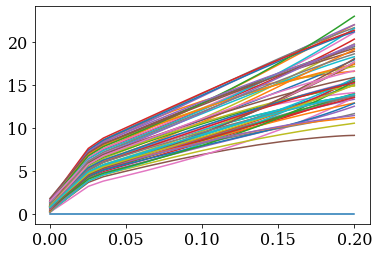

In [36]:
for i in range(0,6000,100):
    plt.plot(z,Tprofiles[:,i])
plt.show()

In [37]:
import pandas as pd
from pandas import Series

weather1 = pd.read_csv("../Excel/Weather_KVTCRAFT2_2017-06-11_2018-03-20.csv", delimiter=",",header=0,date_parser=[1])
weather2 = pd.read_csv("../Excel/Weather_KVTCRAFT2_2018-03-23_2018-10-16.csv", delimiter=",",header=0,date_parser=[1])
weather = [weather1, weather2]
weather = pd.concat(weather)
weather['time'] = pd.to_timedelta(weather['time'].astype(str))
weather['date'] = pd.to_datetime(weather['date'])
weather['date'] = weather['date'] + weather['time']
weather['date'] = pd.to_datetime(weather['date'])

# weather.set_index('date')
weather.columns

Index(['date', 'time', 'temperature', 'dewpoint', 'humidity', 'wind_speed',
       'wind_gust_speed', 'wind_dir_degrees', 'wind_dir', 'pressure',
       'windchill', 'heatindex', 'precip', 'precip_rate', 'precip_1hr',
       'precip_today', 'solarradiation', 'uv_index', 'temperature_indoor',
       'humidity_indoor', 'software_type', 'event', 'conditions'],
      dtype='object')

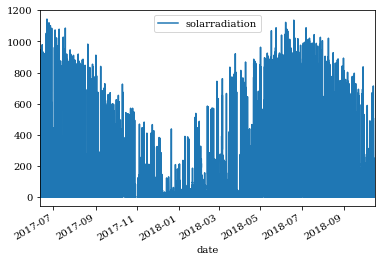

In [42]:
ax = weather.plot(x='date', y = 'solarradiation')
# ax.set_xlim(sensor811.index[0],sensor811.index[-1])

In [58]:
df_solar = pd.DataFrame(pd.to_datetime(weather['date'].astype('str'),infer_datetime_format=True),columns=['date'])
df_solar['qdblprime'] = weather['solarradiation']
df_solar = df_solar.set_index(['date'])
df_solar_30 = df_solar.resample('30Min').mean()
df_solar_30_clean = df_solar_30.interpolate(method='linear')
sub_df_solar_30 = df_solar_30_clean['2018-05-01':'2018-10-01']
irradiation = np.array(sub_df_solar_30['qdblprime'])


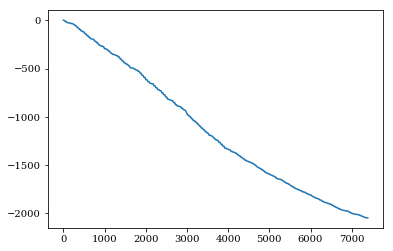

-0.2767503551136363


In [59]:
dt = 1800.
rho = 800
h_L= 3e5
A = 200
N = sub_df_solar_30.shape[0]
V = 0
cst = dt/(rho*h_L)
Vi = -cst*irradiation*A
Vicumsum = np.cumsum(Vi)
plt.plot(Vicumsum)
plt.show()
# sub_df_solar_30['Volume loss'] =
# sub_df_solar_30.plot()
print(np.mean(Vi))

## Assignment

Write a code that predict volume loss of over a given period of time using solar radiation data. Assume that the whole solar radiation affects the pile.